In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm
from sklearn.utils import resample

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']

project_dir = os.path.expanduser('~/RL_2024/')

In [2]:
γ = 1.0  # discount factor for evaluation

nS = 750
nA = 25

nS_term = 2
S_survival = 750
S_death = 751

nS_total = nS + nS_term

## Load Everything

In [3]:
with open(project_dir + 'data/env_model/gymP_orig.pkl', 'rb') as f:
    gymP_orig = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_dropped.pkl', 'rb') as f:
    gymP_dropped = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_shifted.pkl', 'rb') as f:
    gymP_shifted = pickle.load(f)

π_b_orig = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_orig.pkl').values
π_b_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_dropped.pkl').values
π_b_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_shifted.pkl').values

SA_mask_orig = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_orig.pkl').values
SA_mask_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_dropped.pkl').values
SA_mask_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_shifted.pkl').values

In [4]:
df_train_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

df_train_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

df_train_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

In [5]:
with open(project_dir + 'data/value_funcs/VI_orig__Vs.pkl', 'rb') as f:
    Vs_orig = pickle.load(f)

with open(project_dir + 'data/value_funcs/VI_dropped__Vs.pkl', 'rb') as f:
    Vs_dropped = pickle.load(f)

with open(project_dir + 'data/value_funcs/VI_shifted__Vs.pkl', 'rb') as f:
    Vs_shifted = pickle.load(f)

## Helper functions

In [6]:
def convert_traj_format(df_traj):
    traj = []
    for t, transition in df_traj.iterrows():
        traj.append({
            't': transition['step'],
            's': transition['s:state'],
            'a': transition['a:action'],
            'r': transition['r:reward'],
            's_': transition['s:next_state'],
            'a_': transition['a:next_action'],
            'done': transition['done'],
        })
    return traj

In [8]:
def V2Q(V, gymP, nS, nA, gamma):
    Q = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            Q[s, a] = sum(p * (r + (0 if done else gamma * V[s_])) for p, s_, r, done in gymP[s][a])
    return Q  # save full Q-value matrix

def policy_eval(gymP, π, nS, nA, gamma, max_iter=None):
    V = np.zeros(nS)
    num_iter = 0
    while not max_iter or num_iter < max_iter:
        V_new = V.copy()
        for s in range(nS):
            ## V[s] = sum {a} π(a|s) sum {s', r} P[s', r | s, a] * (r + gamma * V[s'])
            Q_s = np.zeros(nA)
            for a in range(nA):
                Q_s[a] = sum(p * (r + (0 if done else gamma * V[s_])) for p, s_, r, done in gymP[s][a])
            V_new[s] = np.sum(π[s] * Q_s)
        if np.isclose(np.linalg.norm(V_new - V), 1e-10):
            break
        V = V_new
        num_iter += 1
    return V

In [9]:
def IS(trajectories, π_e, π_b, clip_rho=None, clip_value=None):
    N = len(trajectories)
    G_list = []
    rho_list = []
    for traj in trajectories:
        G = traj[-1]['r']  # G = r_T
        prob_e = []
        prob_b = []
        for t, transition in enumerate(traj):
            s = transition['s']
            a = transition['a']
            prob_e.append(π_e[s,a])
            prob_b.append(π_b[s,a])
        prob_e = np.array(prob_e)
        prob_b = np.array(prob_b)
        rho = (prob_e / prob_b).prod()
        G_list.append(G)
        rho_list.append(rho)
    
    G_list = np.array(G_list)
    rho_list = np.array(rho_list)
    if clip_rho is not None:
        rho_list = np.clip(rho_list, clip_rho[0], clip_rho[1])
    
    V_IS_list = G_list * rho_list
    if clip_value is not None:
        V_IS_list = np.clip(V_IS_list, clip_value[0], clip_value[1])
    
    V_IS = np.sum(V_IS_list) / N
    return V_IS, {
        'V_IS': V_IS,
        'V_WIS': np.sum(G_list * rho_list) / np.sum(rho_list),
        'ESS_IS': np.sum(rho_list) ** 2 / np.sum(rho_list ** 2),
        'G_list': G_list,
        'rho_list': rho_list,
        'V_IS_list': G_list * rho_list,
        'V_WIS_list': G_list * rho_list / np.sum(rho_list) * N,
    }

In [10]:
def perdecision_DR_recursive(trajectories, π_e, π_b, Q_hat, V_hat, gamma, clip_rho=None, clip_value=None):
    """
    Per-decision doubly robust estimator for off-policy evaluation.
    Recursive definition based on Jiang & Li (2016), https://arxiv.org/pdf/1511.03722
    """
    N = len(trajectories)
    v_list = []
    for i, traj in enumerate(trajectories):
        G = 0
        for t in reversed(range(len(traj))):
            transition = traj[t]
            s = transition['s']
            a = transition['a']
            r = transition['r']
            done = transition['done']
            rho = π_e[s, a] / π_b[s, a]
            if clip_rho is not None:
                rho = np.clip(rho, clip_rho[0], clip_rho[1])
            if done:
                G = V_hat[s] + rho * (r - Q_hat[s, a])
            else:
                G = V_hat[s] + rho * (r + gamma * G - Q_hat[s, a])
        
        v_list.append(G)

    v_list = np.array(v_list)
    if clip_value is not None:
        v_list = np.clip(v_list, clip_value[0], clip_value[1])

    v_hat = np.sum(v_list) / N
    return v_hat, {
        'v_hat': v_hat,
        'v_list': v_list,
    }

In [11]:
def perdecision_DR(trajectories, π_e, π_b, Q_hat, V_hat, gamma, clip_rho=None, clip_value=None):
    """
    Per-decision doubly robust estimator for off-policy evaluation.
    Non-recursive definition based on Thomas & Brunskill (2016), https://arxiv.org/pdf/1604.00923
    """
    N = len(trajectories)
    maxH = max(len(df_traj) for df_traj in trajectories)

    rho_list = np.ones((N, maxH))
    for i, traj in enumerate(trajectories):
        for t, transition in enumerate(traj):
            s = transition['s']
            a = transition['a']
            rho = π_e[s, a] / π_b[s, a]
            if clip_rho is not None:
                rho = np.clip(rho, clip_rho[0], clip_rho[1])
            rho_list[i, t] = rho
    
    # Calculate cumulative importance ratio, rho_{1:t} for each trajectory at each timestep
    rho_cumulative = np.cumprod(rho_list, axis=1)

    # # Calculate the average cumulative importance ratio at every horizon t
    # rho_normalization = np.mean(rho_cumulative, axis=0)

    v_list = []
    for i, traj in enumerate(trajectories):
        G = 0
        for t, transition in enumerate(traj):
            s = transition['s']
            a = transition['a']
            r = transition['r']
            rho_1t = rho_cumulative[i, t]
            if t == 0:
                rho_1t_1 = 1.0
            else:
                rho_1t_1 = rho_cumulative[i, t-1]
            G = G + np.power(gamma, t) * (rho_1t * r - (rho_1t * Q_hat[s,a] - rho_1t_1 * V_hat[s]))
        v_list.append(G)
    
    v_list = np.array(v_list)
    if clip_value is not None:
        v_list = np.clip(v_list, clip_value[0], clip_value[1])
    
    v_hat = np.sum(v_list) / N
    return v_hat, {
        'v_hat': v_hat,
        'v_list': v_list,
    }

In [12]:
def perdecision_WDR(trajectories, π_e, π_b, Q_hat, V_hat, gamma, clip_rho=None, clip_value=None):
    """
    Per-decision weighted doubly robust estimator for off-policy evaluation.
    Non-recursive definition based on Thomas & Brunskill (2016), https://arxiv.org/pdf/1604.00923
    """
    N = len(trajectories)
    maxH = max(len(df_traj) for df_traj in trajectories)

    rho_list = np.ones((N, maxH))
    for i, traj in enumerate(trajectories):
        for t, transition in enumerate(traj):
            s = transition['s']
            a = transition['a']
            rho = π_e[s, a] / π_b[s, a]
            if clip_rho is not None:
                rho = np.clip(rho, clip_rho[0], clip_rho[1])
            rho_list[i, t] = rho
    
    # Calculate cumulative importance ratio, rho_{1:t} for each trajectory at each timestep
    rho_cumulative = np.cumprod(rho_list, axis=1)

    # Calculate the average cumulative importance ratio at every horizon t
    rho_normalization = np.mean(rho_cumulative, axis=0)

    v_list = []
    for i, traj in enumerate(trajectories):
        G = 0
        for t, transition in enumerate(traj):
            s = transition['s']
            a = transition['a']
            r = transition['r']
            rho_1t = rho_cumulative[i, t] / rho_normalization[t]
            if t == 0:
                rho_1t_1 = 1.0
            else:
                rho_1t_1 = rho_cumulative[i, t-1] / rho_normalization[t-1]
            G = G + np.power(gamma, t) * (rho_1t * r - (rho_1t * Q_hat[s,a] - rho_1t_1 * V_hat[s]))
        v_list.append(G)
    
    v_list = np.array(v_list)
    if clip_value is not None:
        v_list = np.clip(v_list, clip_value[0], clip_value[1])
    
    v_hat = np.sum(v_list) / N
    return v_hat, {
        'v_hat': v_hat,
        'v_list': v_list,
    }

In [13]:
def boostrap_OPE_estimates(v_list, n_bootstrap=1000):
    """
    Bootstrap 95% confidence interval for OPE estimates.
    """
    N = len(v_list)
    bootstrap_estimates = []
    
    for i in range(n_bootstrap):
        bootstrap_samples = resample(v_list, replace=True, random_state=i)
        bootstrap_estimates.append(np.mean(bootstrap_samples))
    
    return bootstrap_estimates

In [14]:
def bootstrap_WIS(OPE_stats, n_bootstrap=1000):
    """
    Bootstrap 95% confidence interval for WIS estimates.
    """
    N = len(OPE_stats['V_WIS_list'])
    bootstrap_estimates = []
    
    for i in range(n_bootstrap):
        G_list_boot, rho_list_boot = resample(OPE_stats['G_list'], OPE_stats['rho_list'], replace=True, random_state=i)
        V_WIS_boot = np.sum(G_list_boot * rho_list_boot) / np.sum(rho_list_boot)
        bootstrap_estimates.append(V_WIS_boot)
    
    return bootstrap_estimates

## Dropped Timestep

In [15]:
gymP = gymP_dropped
π_b = π_b_dropped
SA_mask = SA_mask_dropped
df_train = df_train_dropped
df_val = df_val_dropped
df_test = df_test_dropped
Vs = Vs_dropped

In [16]:
# remove trajectories with no usable transitions
# (i.e., transitions with zero probability under the behavior policy)
trajectories_test = []
for i, traj in tqdm(df_test.groupby('traj'), total=len(df_test['traj'].unique())):
    usable = True
    for t, transition in traj.iterrows():
        s = transition['s:state']
        a = transition['a:action']
        if np.isclose(π_b[s,a], 0.0):
            usable = False
            break
    if usable:
        trajectories_test.append(convert_traj_format(traj))

100%|██████████| 2895/2895 [00:06<00:00, 475.81it/s]


In [20]:
# recalculate the value functions - different discount
V_b = policy_eval(gymP, π_b, nS, nA, γ, max_iter=None)  # <- takes about 12 seconds
Q_b = V2Q(V_b, gymP, nS, nA, γ)

In [21]:
# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

# recalculate the value functions - different discount
V_star = policy_eval(gymP, π_star, nS, nA, γ, max_iter=20)
Q_star = V2Q(V_star, gymP, nS, nA, γ)


In [23]:
# Soften policy to create evaluation policy
epsilon = 0.05
π_e = (1 - epsilon) * π_star + epsilon * π_b

# recalculate the value functions for evaluation policy
V_e = policy_eval(gymP, π_e, nS, nA, γ, max_iter=20)
Q_e = V2Q(V_e, gymP, nS, nA, γ)

In [24]:
# Observed test set returns
V_TEST = []
for i, traj in enumerate(trajectories_test):
    H = len(traj)
    G = 0
    for t in reversed(range(H)):
        G = traj[t]['r'] + γ * G
    V_TEST.append(G)

In [25]:
print(df_test['traj'].nunique(), df_test.groupby('traj')['r:reward'].sum().mean())
print(len(trajectories_test), np.mean(V_TEST))

2895 0.8058721934369603
2462 0.8318440292445166


In [26]:
V_IS_π_b, IS_stats_π_b = IS(trajectories_test, π_b, π_b, clip_rho=(1e-3, 1e3))
V_IS_π_b_bootstrap = boostrap_OPE_estimates(IS_stats_π_b['V_IS_list'], n_bootstrap=1000)
V_WIS_π_b = IS_stats_π_b['V_WIS']
V_WIS_π_b_bootstrap = bootstrap_WIS(IS_stats_π_b, n_bootstrap=1000)
V_DR_π_b, DR_stats_π_b = perdecision_DR(trajectories_test, π_b, π_b, Q_b, V_b, γ, clip_value=(-1, 1))
V_DR_π_b_bootstrap = boostrap_OPE_estimates(DR_stats_π_b['v_list'], n_bootstrap=1000)
V_WDR_π_b, WDR_stats_π_b = perdecision_WDR(trajectories_test, π_b, π_b, Q_b, V_b, γ, clip_value=(-1, 1))
V_WDR_π_b_bootstrap = boostrap_OPE_estimates(WDR_stats_π_b['v_list'], n_bootstrap=1000)
print('IS: {:.3f}'.format(V_IS_π_b), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_IS_π_b_bootstrap, 2.5), np.percentile(V_IS_π_b_bootstrap, 97.5)))
print('WIS: {:.3f}'.format(V_WIS_π_b), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WIS_π_b_bootstrap, 2.5), np.percentile(V_WIS_π_b_bootstrap, 97.5)))
print('ESS:', IS_stats_π_b['ESS_IS'])
print('DR: {:.3f} ± {:.3f}'.format(V_DR_π_b, np.std(V_DR_π_b_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_DR_π_b_bootstrap, 2.5), np.percentile(V_DR_π_b_bootstrap, 97.5)))
print('WDR: {:.3f} ± {:.3f}'.format(V_WDR_π_b, np.std(V_WDR_π_b_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WDR_π_b_bootstrap, 2.5), np.percentile(V_WDR_π_b_bootstrap, 97.5)))

IS: 0.832 95% CI: 0.811, 0.853
WIS: 0.832 95% CI: 0.811, 0.853
ESS: 2462.0
DR: 0.782 ± 0.010 95% CI: 0.762, 0.802
WDR: 0.782 ± 0.010 95% CI: 0.762, 0.802


In [27]:
V_IS_π_e, IS_stats_π_e = IS(trajectories_test, π_e, π_b, clip_rho=(1e-3, 1e3))
V_IS_π_e_bootstrap = boostrap_OPE_estimates(IS_stats_π_e['V_IS_list'], n_bootstrap=1000)
V_WIS_π_e = IS_stats_π_e['V_WIS']
V_WIS_π_e_bootstrap = bootstrap_WIS(IS_stats_π_e, n_bootstrap=1000)
V_DR_π_e, DR_stats_π_e = perdecision_DR(trajectories_test, π_e, π_b, Q_e, V_e, γ, clip_value=(-1, 1))
V_DR_π_e_bootstrap = boostrap_OPE_estimates(DR_stats_π_e['v_list'], n_bootstrap=1000)
V_WDR_π_e, WDR_stats_π_e = perdecision_WDR(trajectories_test, π_e, π_b, Q_e, V_e, γ, clip_value=(-1, 1))
V_WDR_π_e_bootstrap = boostrap_OPE_estimates(WDR_stats_π_e['v_list'], n_bootstrap=1000)
print('IS: {:.3f}'.format(V_IS_π_e), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_IS_π_e_bootstrap, 2.5), np.percentile(V_IS_π_e_bootstrap, 97.5)))
print('WIS: {:.3f}'.format(V_WIS_π_e), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WIS_π_e_bootstrap, 2.5), np.percentile(V_WIS_π_e_bootstrap, 97.5)))
print('ESS:', IS_stats_π_e['ESS_IS'])
print('DR: {:.3f} ± {:.3f}'.format(V_DR_π_e, np.std(V_DR_π_e_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_DR_π_e_bootstrap, 2.5), np.percentile(V_DR_π_e_bootstrap, 97.5)))
print('WDR: {:.3f} ± {:.3f}'.format(V_WDR_π_e, np.std(V_WDR_π_e_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WDR_π_e_bootstrap, 2.5), np.percentile(V_WDR_π_e_bootstrap, 97.5)))

IS: 5.289 95% CI: 2.311, 8.555
WIS: 0.671 95% CI: 0.336, 0.954
ESS: 23.02669519210322
DR: 0.864 ± 0.006 95% CI: 0.853, 0.876
WDR: 0.908 ± 0.003 95% CI: 0.900, 0.914


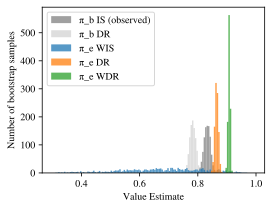

In [28]:
fig, ax = plt.subplots(figsize=(4,3))
plt.hist(V_IS_π_b_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), color='gray', fc='gray', label='π_b IS (observed)')
plt.hist(V_DR_π_b_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), color='lightgray', fc='lightgray', label='π_b DR')
plt.hist(V_WIS_π_e_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), label='π_e WIS')
plt.hist(V_DR_π_e_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), label='π_e DR')
plt.hist(V_WDR_π_e_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), label='π_e WDR')
plt.xlabel('Value Estimate')
plt.ylabel('Number of bootstrap samples')
plt.legend()
plt.show()

## Shifted Timestep

In [29]:
gymP = gymP_shifted
π_b = π_b_shifted
SA_mask = SA_mask_shifted
df_train = df_train_shifted
df_val = df_val_shifted
df_test = df_test_shifted
Vs = Vs_shifted

In [30]:
# remove trajectories with no usable transitions
# (i.e., transitions with zero probability under the behavior policy)
trajectories_test = []
for i, traj in tqdm(df_test.groupby('traj'), total=len(df_test['traj'].unique())):
    usable = True
    for t, transition in traj.iterrows():
        s = transition['s:state']
        a = transition['a:action']
        if np.isclose(π_b[s,a], 0.0):
            usable = False
            break
    if usable:
        trajectories_test.append(convert_traj_format(traj))

100%|██████████| 2895/2895 [00:06<00:00, 474.62it/s]


In [31]:
# recalculate the value functions - different discount
V_b = policy_eval(gymP, π_b, nS, nA, γ, max_iter=None)  # <- takes about 12 seconds
Q_b = V2Q(V_b, gymP, nS, nA, γ)

In [32]:
# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

# recalculate the value functions - different discount
V_star = policy_eval(gymP, π_star, nS, nA, γ, max_iter=20)
Q_star = V2Q(V_star, gymP, nS, nA, γ)


In [33]:
# Soften policy to create evaluation policy
epsilon = 0.05
π_e = (1 - epsilon) * π_star + epsilon * π_b

# recalculate the value functions for evaluation policy
V_e = policy_eval(gymP, π_e, nS, nA, γ, max_iter=20)
Q_e = V2Q(V_e, gymP, nS, nA, γ)

In [34]:
# Observed test set returns
V_TEST = []
for i, traj in enumerate(trajectories_test):
    H = len(traj)
    G = 0
    for t in reversed(range(H)):
        G = traj[t]['r'] + γ * G
    V_TEST.append(G)

In [35]:
print(df_test['traj'].nunique(), df_test.groupby('traj')['r:reward'].sum().mean())
print(len(trajectories_test), np.mean(V_TEST))

2895 0.8058721934369603
2392 0.8377926421404682


In [36]:
V_IS_π_b, IS_stats_π_b = IS(trajectories_test, π_b, π_b, clip_rho=(1e-3, 1e3))
V_IS_π_b_bootstrap = boostrap_OPE_estimates(IS_stats_π_b['V_IS_list'], n_bootstrap=1000)
V_WIS_π_b = IS_stats_π_b['V_WIS']
V_WIS_π_b_bootstrap = bootstrap_WIS(IS_stats_π_b, n_bootstrap=1000)
V_DR_π_b, DR_stats_π_b = perdecision_DR(trajectories_test, π_b, π_b, Q_b, V_b, γ, clip_value=(-1, 1))
V_DR_π_b_bootstrap = boostrap_OPE_estimates(DR_stats_π_b['v_list'], n_bootstrap=1000)
V_WDR_π_b, WDR_stats_π_b = perdecision_WDR(trajectories_test, π_b, π_b, Q_b, V_b, γ, clip_value=(-1, 1))
V_WDR_π_b_bootstrap = boostrap_OPE_estimates(WDR_stats_π_b['v_list'], n_bootstrap=1000)
print('IS: {:.3f}'.format(V_IS_π_b), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_IS_π_b_bootstrap, 2.5), np.percentile(V_IS_π_b_bootstrap, 97.5)))
print('WIS: {:.3f}'.format(V_WIS_π_b), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WIS_π_b_bootstrap, 2.5), np.percentile(V_WIS_π_b_bootstrap, 97.5)))
print('ESS:', IS_stats_π_b['ESS_IS'])
print('DR: {:.3f} ± {:.3f}'.format(V_DR_π_b, np.std(V_DR_π_b_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_DR_π_b_bootstrap, 2.5), np.percentile(V_DR_π_b_bootstrap, 97.5)))
print('WDR: {:.3f} ± {:.3f}'.format(V_WDR_π_b, np.std(V_WDR_π_b_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WDR_π_b_bootstrap, 2.5), np.percentile(V_WDR_π_b_bootstrap, 97.5)))

IS: 0.838 95% CI: 0.814, 0.859
WIS: 0.838 95% CI: 0.814, 0.859
ESS: 2392.0
DR: 0.777 ± 0.011 95% CI: 0.755, 0.796
WDR: 0.777 ± 0.011 95% CI: 0.755, 0.796


In [37]:
V_IS_π_e, IS_stats_π_e = IS(trajectories_test, π_e, π_b, clip_rho=(1e-3, 1e3))
V_IS_π_e_bootstrap = boostrap_OPE_estimates(IS_stats_π_e['V_IS_list'], n_bootstrap=1000)
V_WIS_π_e = IS_stats_π_e['V_WIS']
V_WIS_π_e_bootstrap = bootstrap_WIS(IS_stats_π_e, n_bootstrap=1000)
V_DR_π_e, DR_stats_π_e = perdecision_DR(trajectories_test, π_e, π_b, Q_e, V_e, γ, clip_value=(-1, 1))
V_DR_π_e_bootstrap = boostrap_OPE_estimates(DR_stats_π_e['v_list'], n_bootstrap=1000)
V_WDR_π_e, WDR_stats_π_e = perdecision_WDR(trajectories_test, π_e, π_b, Q_e, V_e, γ, clip_value=(-1, 1))
V_WDR_π_e_bootstrap = boostrap_OPE_estimates(WDR_stats_π_e['v_list'], n_bootstrap=1000)
print('IS: {:.3f}'.format(V_IS_π_e), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_IS_π_e_bootstrap, 2.5), np.percentile(V_IS_π_e_bootstrap, 97.5)))
print('WIS: {:.3f}'.format(V_WIS_π_e), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WIS_π_e_bootstrap, 2.5), np.percentile(V_WIS_π_e_bootstrap, 97.5)))
print('ESS:', IS_stats_π_e['ESS_IS'])
print('DR: {:.3f} ± {:.3f}'.format(V_DR_π_e, np.std(V_DR_π_e_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_DR_π_e_bootstrap, 2.5), np.percentile(V_DR_π_e_bootstrap, 97.5)))
print('WDR: {:.3f} ± {:.3f}'.format(V_WDR_π_e, np.std(V_WDR_π_e_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WDR_π_e_bootstrap, 2.5), np.percentile(V_WDR_π_e_bootstrap, 97.5)))

IS: 23.980 95% CI: 18.072, 30.191
WIS: 0.926 95% CI: 0.826, 0.998
ESS: 70.56701987510786
DR: 0.870 ± 0.007 95% CI: 0.855, 0.884
WDR: 0.929 ± 0.003 95% CI: 0.922, 0.936


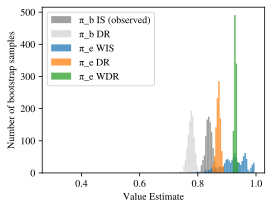

In [38]:
fig, ax = plt.subplots(figsize=(4,3))
plt.hist(V_IS_π_b_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), color='gray', fc='gray', label='π_b IS (observed)')
plt.hist(V_DR_π_b_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), color='lightgray', fc='lightgray', label='π_b DR')
plt.hist(V_WIS_π_e_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), label='π_e WIS')
plt.hist(V_DR_π_e_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), label='π_e DR')
plt.hist(V_WDR_π_e_bootstrap, alpha=0.75, bins=np.arange(0.3, 1.0, 0.005), label='π_e WDR')
plt.xlabel('Value Estimate')
plt.ylabel('Number of bootstrap samples')
plt.legend()
plt.show()

## Cross eval

Learn using dropped, evaluate using shifted

In [39]:
gymP_learn = gymP_dropped
Vs = Vs_dropped
SA_mask = SA_mask_dropped

π_b = π_b_shifted
gymP_eval = gymP_shifted
df_test = df_test_shifted

In [40]:
# remove trajectories with no usable transitions
# (i.e., transitions with zero probability under the behavior policy)
trajectories_test = []
for i, traj in tqdm(df_test.groupby('traj'), total=len(df_test['traj'].unique())):
    usable = True
    for t, transition in traj.iterrows():
        s = transition['s:state']
        a = transition['a:action']
        if np.isclose(π_b[s,a], 0.0):
            usable = False
            break
    if usable:
        trajectories_test.append(convert_traj_format(traj))

100%|██████████| 2895/2895 [00:06<00:00, 477.29it/s]


In [41]:
# recalculate the value functions - different discount
V_b = policy_eval(gymP_eval, π_b, nS, nA, γ, max_iter=None)  # <- takes about 12 seconds
Q_b = V2Q(V_b, gymP_eval, nS, nA, γ)

In [45]:
# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP_learn, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

# recalculate the value functions - different discount
V_star = policy_eval(gymP_eval, π_star, nS, nA, γ, max_iter=20)
Q_star = V2Q(V_star, gymP_eval, nS, nA, γ)


In [47]:
# Soften policy to create evaluation policy
epsilon = 0.05
π_e = (1 - epsilon) * π_star + epsilon * π_b

# recalculate the value functions for evaluation policy
V_e = policy_eval(gymP_eval, π_e, nS, nA, γ, max_iter=20)
Q_e = V2Q(V_e, gymP_eval, nS, nA, γ)

In [48]:
# Observed test set returns
V_TEST = []
for i, traj in enumerate(trajectories_test):
    H = len(traj)
    G = 0
    for t in reversed(range(H)):
        G = traj[t]['r'] + γ * G
    V_TEST.append(G)

In [49]:
print(df_test['traj'].nunique(), df_test.groupby('traj')['r:reward'].sum().mean())
print(len(trajectories_test), np.mean(V_TEST))

2895 0.8058721934369603
2392 0.8377926421404682


In [50]:
V_IS_π_b, IS_stats_π_b = IS(trajectories_test, π_b, π_b, clip_rho=(1e-3, 1e3))
V_IS_π_b_bootstrap = boostrap_OPE_estimates(IS_stats_π_b['V_IS_list'], n_bootstrap=1000)
V_WIS_π_b = IS_stats_π_b['V_WIS']
V_WIS_π_b_bootstrap = bootstrap_WIS(IS_stats_π_b, n_bootstrap=1000)
V_DR_π_b, DR_stats_π_b = perdecision_DR(trajectories_test, π_b, π_b, Q_b, V_b, γ, clip_value=(-1, 1))
V_DR_π_b_bootstrap = boostrap_OPE_estimates(DR_stats_π_b['v_list'], n_bootstrap=1000)
V_WDR_π_b, WDR_stats_π_b = perdecision_WDR(trajectories_test, π_b, π_b, Q_b, V_b, γ, clip_value=(-1, 1))
V_WDR_π_b_bootstrap = boostrap_OPE_estimates(WDR_stats_π_b['v_list'], n_bootstrap=1000)
print('IS: {:.3f}'.format(V_IS_π_b), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_IS_π_b_bootstrap, 2.5), np.percentile(V_IS_π_b_bootstrap, 97.5)))
print('WIS: {:.3f}'.format(V_WIS_π_b), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WIS_π_b_bootstrap, 2.5), np.percentile(V_WIS_π_b_bootstrap, 97.5)))
print('ESS:', IS_stats_π_b['ESS_IS'])
print('DR: {:.3f} ± {:.3f}'.format(V_DR_π_b, np.std(V_DR_π_b_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_DR_π_b_bootstrap, 2.5), np.percentile(V_DR_π_b_bootstrap, 97.5)))
print('WDR: {:.3f} ± {:.3f}'.format(V_WDR_π_b, np.std(V_WDR_π_b_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WDR_π_b_bootstrap, 2.5), np.percentile(V_WDR_π_b_bootstrap, 97.5)))

IS: 0.838 95% CI: 0.814, 0.859
WIS: 0.838 95% CI: 0.814, 0.859
ESS: 2392.0
DR: 0.777 ± 0.011 95% CI: 0.755, 0.796
WDR: 0.777 ± 0.011 95% CI: 0.755, 0.796


In [51]:
V_IS_π_e, IS_stats_π_e = IS(trajectories_test, π_e, π_b, clip_rho=(1e-3, 1e3))
V_IS_π_e_bootstrap = boostrap_OPE_estimates(IS_stats_π_e['V_IS_list'], n_bootstrap=1000)
V_WIS_π_e = IS_stats_π_e['V_WIS']
V_WIS_π_e_bootstrap = bootstrap_WIS(IS_stats_π_e, n_bootstrap=1000)
V_DR_π_e, DR_stats_π_e = perdecision_DR(trajectories_test, π_e, π_b, Q_e, V_e, γ, clip_value=(-1, 1))
V_DR_π_e_bootstrap = boostrap_OPE_estimates(DR_stats_π_e['v_list'], n_bootstrap=1000)
V_WDR_π_e, WDR_stats_π_e = perdecision_WDR(trajectories_test, π_e, π_b, Q_e, V_e, γ, clip_value=(-1, 1))
V_WDR_π_e_bootstrap = boostrap_OPE_estimates(WDR_stats_π_e['v_list'], n_bootstrap=1000)
print('IS: {:.3f}'.format(V_IS_π_e), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_IS_π_e_bootstrap, 2.5), np.percentile(V_IS_π_e_bootstrap, 97.5)))
print('WIS: {:.3f}'.format(V_WIS_π_e), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WIS_π_e_bootstrap, 2.5), np.percentile(V_WIS_π_e_bootstrap, 97.5)))
print('ESS:', IS_stats_π_e['ESS_IS'])
print('DR: {:.3f} ± {:.3f}'.format(V_DR_π_e, np.std(V_DR_π_e_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_DR_π_e_bootstrap, 2.5), np.percentile(V_DR_π_e_bootstrap, 97.5)))
print('WDR: {:.3f} ± {:.3f}'.format(V_WDR_π_e, np.std(V_WDR_π_e_bootstrap)), '95% CI: {:.3f}, {:.3f}'.format(np.percentile(V_WDR_π_e_bootstrap, 2.5), np.percentile(V_WDR_π_e_bootstrap, 97.5)))

IS: 6.060 95% CI: 2.597, 9.606
WIS: 0.620 95% CI: 0.296, 0.894
ESS: 27.83522876812906
DR: 0.782 ± 0.007 95% CI: 0.767, 0.795
WDR: 0.829 ± 0.004 95% CI: 0.821, 0.837
